In [2]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
from pyFTS.benchmarks import Measures
import math
from pyFTS.common import Util
import datetime
import statistics
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

## Aux functions

In [3]:
# convert series to supervised learning
def series_to_supervised_miso(data, n_in, n_out, endog_var, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [(df.columns[j]+'(t-%d)' % (i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df[endog_var].shift(-i))
		if i == 0:
			names += [(endog_var+'(t)')]
		else:
			names += [(endog_var+'(t+%d)' % (i))]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [4]:
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame) 
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64)

## Dataset Smart Home with Weather information

In [5]:
df = pd.read_csv('/home/hugo/projetos-doutorado/Appliance-Energy-Prediction/data/HomeC.csv')
data = df.drop(labels=['icon','summary','cloudCover', 'House overall [kW]', 'time'], axis=1)
data = data.loc[0: : 10]
data
data.dropna(inplace=True)
data = clean_dataset(data)
values = data.values
data.head()

/home/hugo/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (0,27) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,use [kW],gen [kW],Dishwasher [kW],Furnace 1 [kW],Furnace 2 [kW],Home office [kW],Fridge [kW],Wine cellar [kW],Garage door [kW],Kitchen 12 [kW],...,temperature,humidity,visibility,apparentTemperature,pressure,windSpeed,windBearing,precipIntensity,dewPoint,precipProbability
0,0.932833,0.003483,0.000033,0.020700,0.061917,0.442633,0.124150,0.006983,0.013083,0.000417,...,36.14,0.62,10.0,29.26,1016.91,9.18,282.0,0.0,24.4,0.0
10,1.585083,0.003417,0.000050,0.022100,0.678733,0.440200,0.121450,0.007433,0.013583,0.000350,...,36.14,0.62,10.0,29.26,1016.91,9.18,282.0,0.0,24.4,0.0
20,0.533817,0.003450,0.000000,0.020633,0.062967,0.270033,0.004950,0.007033,0.013117,0.000750,...,36.14,0.62,10.0,29.26,1016.91,9.18,282.0,0.0,24.4,0.0
30,1.190950,0.003083,0.000217,0.387400,0.061883,0.256867,0.004933,0.101783,0.012533,0.000700,...,36.14,0.62,10.0,29.26,1016.91,9.18,282.0,0.0,24.4,0.0
40,1.582083,0.003067,0.000050,0.022050,0.681717,0.242433,0.005550,0.122400,0.013550,0.000567,...,36.14,0.62,10.0,29.26,1016.91,9.18,282.0,0.0,24.4,0.0


## Dataset Smart Home with Weather information: Preprocessing, Lag = 1, t+1

In [7]:
cols = data.columns
list_cols = list(cols)

In [8]:
# normalize features
scaler = MinMaxScaler()
scaled = scaler.fit_transform(values)
data_scaled = pd.DataFrame(scaled, columns=list_cols)
# frame as supervised learning
data_scaled = series_to_supervised_miso(data_scaled, 1, 1,endog_var='use [kW]')
data_scaled.head()

,use [kW](t-1),gen [kW](t-1),Dishwasher [kW](t-1),Furnace 1 [kW](t-1),Furnace 2 [kW](t-1),Home office [kW](t-1),Fridge [kW](t-1),Wine cellar [kW](t-1),Garage door [kW](t-1),Kitchen 12 [kW](t-1),...,humidity(t-1),visibility(t-1),apparentTemperature(t-1),pressure(t-1),windSpeed(t-1),windBearing(t-1),precipIntensity(t-1),dewPoint(t-1),precipProbability(t-1),use [kW](t)
1,0.072766,0.005898,0.000024,0.010888,0.077812,0.602792,0.157918,0.005668,0.012850,0.000455,...,0.576471,1.0,0.460511,0.544238,0.400698,0.785515,0.0,0.502677,0.0,0.123647
2,0.123647,0.005785,0.000036,0.011633,0.853812,0.599478,0.154481,0.006034,0.013343,0.000382,...,0.576471,1.0,0.460511,0.544238,0.400698,0.785515,0.0,0.502677,0.0,0.041640
3,0.041640,0.005842,0.000000,0.010852,0.079133,0.367696,0.006174,0.005709,0.012882,0.000818,...,0.576471,1.0,0.460511,0.544238,0.400698,0.785515,0.0,0.502677,0.0,0.092901
4,0.092901,0.005221,0.000155,0.205963,0.077770,0.349762,0.006153,0.082798,0.012307,0.000764,...,0.576471,1.0,0.460511,0.544238,0.400698,0.785515,0.0,0.502677,0.0,0.123413
5,0.123413,0.005193,0.000036,0.011606,0.857565,0.330102,0.006938,0.099571,0.013310,0.000618,...,0.576471,1.0,0.460511,0.544238,0.400698,0.785515,0.0,0.502677,0.0,0.065290


In [9]:
data = series_to_supervised_miso(data, 1, 1,endog_var='use [kW]')
data.head()

,use [kW](t-1),gen [kW](t-1),Dishwasher [kW](t-1),Furnace 1 [kW](t-1),Furnace 2 [kW](t-1),Home office [kW](t-1),Fridge [kW](t-1),Wine cellar [kW](t-1),Garage door [kW](t-1),Kitchen 12 [kW](t-1),...,humidity(t-1),visibility(t-1),apparentTemperature(t-1),pressure(t-1),windSpeed(t-1),windBearing(t-1),precipIntensity(t-1),dewPoint(t-1),precipProbability(t-1),use [kW](t)
10,0.932833,0.003483,0.000033,0.020700,0.061917,0.442633,0.124150,0.006983,0.013083,0.000417,...,0.62,10.0,29.26,1016.91,9.18,282.0,0.0,24.4,0.0,1.585083
20,1.585083,0.003417,0.000050,0.022100,0.678733,0.440200,0.121450,0.007433,0.013583,0.000350,...,0.62,10.0,29.26,1016.91,9.18,282.0,0.0,24.4,0.0,0.533817
30,0.533817,0.003450,0.000000,0.020633,0.062967,0.270033,0.004950,0.007033,0.013117,0.000750,...,0.62,10.0,29.26,1016.91,9.18,282.0,0.0,24.4,0.0,1.190950
40,1.190950,0.003083,0.000217,0.387400,0.061883,0.256867,0.004933,0.101783,0.012533,0.000700,...,0.62,10.0,29.26,1016.91,9.18,282.0,0.0,24.4,0.0,1.582083
50,1.582083,0.003067,0.000050,0.022050,0.681717,0.242433,0.005550,0.122400,0.013550,0.000567,...,0.62,10.0,29.26,1016.91,9.18,282.0,0.0,24.4,0.0,0.837000


In [38]:
round(data.describe(),3)

,use [kW](t-1),gen [kW](t-1),Dishwasher [kW](t-1),Furnace 1 [kW](t-1),Furnace 2 [kW](t-1),Home office [kW](t-1),Fridge [kW](t-1),Wine cellar [kW](t-1),Garage door [kW](t-1),Kitchen 12 [kW](t-1),...,humidity(t-1),visibility(t-1),apparentTemperature(t-1),pressure(t-1),windSpeed(t-1),windBearing(t-1),precipIntensity(t-1),dewPoint(t-1),precipProbability(t-1),use [kW](t)
count,50390.000,50390.000,50390.000,50390.000,50390.000,50390.000,50390.000,50390.000,50390.000,50390.000,...,50390.000,50390.000,50390.000,50390.000,50390.000,50390.000,50390.000,50390.000,50390.000,50390.000
mean,0.860,0.076,0.031,0.099,0.138,0.081,0.064,0.042,0.014,0.003,...,0.664,9.253,48.264,1016.302,6.649,202.390,0.003,38.693,0.056,0.860
std,1.058,0.129,0.190,0.168,0.180,0.104,0.077,0.058,0.012,0.024,...,0.194,1.612,22.030,7.895,3.982,106.545,0.011,19.088,0.166,1.058
min,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.130,0.270,-32.080,986.400,0.000,0.000,0.000,-27.240,0.000,0.000
25%,0.370,0.003,0.000,0.020,0.065,0.040,0.005,0.007,0.013,0.000,...,0.510,9.420,31.090,1011.290,3.660,148.000,0.000,24.600,0.000,0.370
50%,0.564,0.004,0.000,0.021,0.067,0.042,0.005,0.008,0.013,0.001,...,0.680,10.000,50.320,1016.530,5.930,208.000,0.000,39.030,0.000,0.564
75%,0.974,0.084,0.000,0.069,0.081,0.069,0.125,0.052,0.013,0.001,...,0.840,10.000,66.258,1021.480,8.940,295.000,0.000,54.790,0.000,0.974
max,12.819,0.591,1.400,1.880,0.795,0.734,0.786,1.229,1.014,0.916,...,0.980,10.000,101.120,1042.460,22.910,359.000,0.191,75.490,0.840,12.819


## Model: SARIMAX

### Define SARIMAX parameters

In [10]:
values = data.values
values.shape

(50390, 28)

In [24]:
values = data.values
train_size=int(len(values)*0.30)
test_size = int(len(values)) - train_size
print(test_size)

35273


In [26]:
# split into train and test sets
train_X, train_y = data.loc[:,'use [kW](t-1)':'precipProbability(t-1)'].values[:train_size], data['use [kW](t-1)'].values[:train_size]
test_X, test_y = data.loc[:,'use [kW](t-1)':'precipProbability(t-1)'].values[train_size:], data['use [kW](t)'].values[train_size:]

train_y.reshape(-1)
test_y.reshape(-1)


# train_X, train_y = data_scaled.loc[:,'use [kW](t-1)':'precipProbability(t-1)'].values[:train_size], data_scaled['use [kW](t-1)'].values[:train_size]
# test_X, test_y = data_scaled.loc[:,'use [kW](t-1)':'precipProbability(t-1)'].values[train_size:], data_scaled['use [kW](t)'].values[train_size:]

# train_y.reshape(-1)
# test_y.reshape(-1)

# split into input (all columns exceptc last one) and outputs (last column)
# train_X, train_y = train_X[:, :-1], train_y[:, -1]
# test_X, test_y = test_X[:, :-1], test_y[:, -1]

# # reshape input to be 3D [samples, timesteps, features]; each line turns into an 'sub-array'
# train_X = train_X.reshape((train_X.shape[0],train_X.shape[1]))
# test_X = test_X.reshape((test_X.shape[0],test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(15117, 27) (15117,) (35273, 27) (35273,)


In [10]:
# cols = data.columns
# list_cols_exog = list(cols)
# list_cols_exog.remove("use [kW]")

In [11]:
# df_train_X = pd.DataFrame(train_X,columns=list_cols_exog)
# df_test_X = pd.DataFrame(train_X,columns=list_cols_exog)

In [12]:
# list_cols_endog = []
# list_cols_endog.append('use [kW]')
# df_train_y = pd.DataFrame(train_y,columns=list_cols_endog)
# df_test_y = pd.DataFrame(test_y,columns=list_cols_endog)
#df_train_y

In [13]:
# from matplotlib import pyplot
# from statsmodels.graphics.tsaplots import plot_acf
# plot_acf(df_train_y)
# pyplot.show()

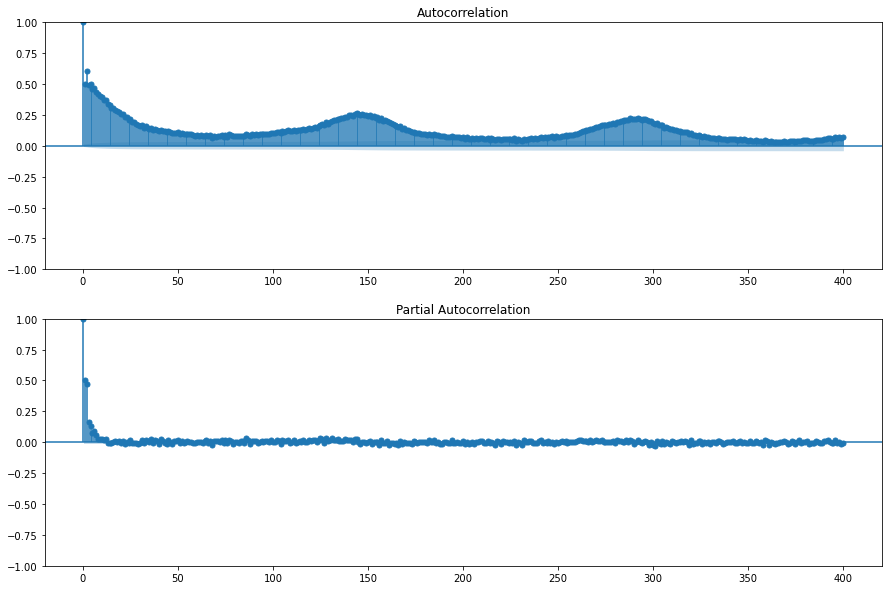

In [16]:
#Correlograms
fig,ax= plt.subplots(2,1, figsize=(15,10))
fig=sm.tsa.graphics.plot_acf(train_y, lags=400, ax=ax[0])
fig=sm.tsa.graphics.plot_pacf(train_y, lags=400, ax=ax[1])
plt.show()

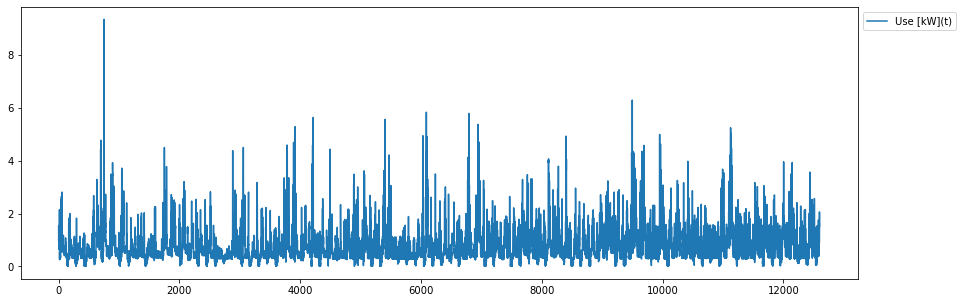

In [20]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[15, 5])
ax.plot(test_y, label='Use [kW](t)')
handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc=2, bbox_to_anchor=(1, 1))
plt.show()

In [27]:
# # # m = 7 => daily
# # # m = 52 => weekly
sarimax_model = auto_arima(train_y,
                       exogenous= train_X,
                       test='adf',
                       start_p=0,
                       start_q=0,
                       max_p=5,
                       max_q=5,
                       start_Q=0,
                       start_P=0,
                       max_P=5,
                       max_Q=5,
                       m=7,
                       seasonal=True,
                       d=None,
                       D=1,
                       max_D=5,
                       trace=True,
                       error_action='ignore',
                       suppress_warnings=True,
                       stepwise=True)
                       #n_fits = 50)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[7] intercept   : AIC=-319943.969, Time=109.59 sec
 ARIMA(1,0,0)(1,1,0)[7] intercept   : AIC=-199807.897, Time=492.34 sec
 ARIMA(0,0,1)(0,1,1)[7] intercept   : AIC=-320083.498, Time=109.37 sec
 ARIMA(0,0,0)(0,1,0)[7]             : AIC=-319945.969, Time=60.07 sec
 ARIMA(0,0,1)(0,1,0)[7] intercept   : AIC=-320083.155, Time=17.74 sec
 ARIMA(0,0,1)(1,1,1)[7] intercept   : AIC=-320082.606, Time=111.74 sec
 ARIMA(0,0,1)(0,1,2)[7] intercept   : AIC=-320081.935, Time=169.46 sec
 ARIMA(0,0,1)(1,1,0)[7] intercept   : AIC=-320082.962, Time=107.11 sec
 ARIMA(0,0,1)(1,1,2)[7] intercept   : AIC=-320080.169, Time=178.05 sec
 ARIMA(0,0,0)(0,1,1)[7] intercept   : AIC=-319952.589, Time=123.20 sec
 ARIMA(1,0,1)(0,1,1)[7] intercept   : AIC=599200193706.967, Time=437.10 sec
 ARIMA(0,0,2)(0,1,1)[7] intercept   : AIC=-131693.711, Time=300.40 sec
 ARIMA(1,0,0)(0,1,1)[7] intercept   : AIC=4003.858, Time=106.56 sec
 ARIMA(1,0,2)(0,1,1)[7] intercept 

In [20]:
#ARIMA(0,0,1)(3,1,1)[7] intercept   : AIC=-90795.546, Time=847.26 sec
#ARIMA(0,0,1)(4,1,3)[7] intercept   : AIC=-54962.100, Time=787.74 sec

#sarimax_model.summary()

In [21]:
# from statsmodels.tsa.statespace.sarimax import SARIMAX
# model= SARIMAX(endog=train_y, 
#  exog=train_X,
#  order=(0,0,1),
#  seasonal_order=(4,1,3,7),
#  enforce_invertibility=False, 
#  enforce_stationarity=False)

In [22]:
# results = model.fit(disp=True)

/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [23]:
# results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                         SARIMAX Results                                         
=================================================================================================
Dep. Variable:                                         y   No. Observations:                37792
Model:             SARIMAX(0, 0, 1)x(4, 1, [1, 2, 3], 7)   Log Likelihood               47530.529
Date:                                   Fri, 17 Sep 2021   AIC                         -94989.058
Time:                                           17:16:04   BIC                         -94681.657
Sample:                                                0   HQIC                        -94891.492
                                                 - 37792                                         
Covariance Type:                                     opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.9549      0.002    487.579      0.000       0.951       0.959
x2             0.0003      0.000      0.961      0.337      -0.000       0.001
x3            -0.0031      0.001     -2.959      0.003      -0.005      -0.001
x4             0.0010      0.002      0.489      0.625      -0.003       0.005
x5            -0.0026      0.001     -2.422      0.015      -0.005      -0.000
x6             0.0019      0.001      2.534      0.011       0.000       0.003
x7            -0.0088      0.002     -5.433      0.000      -0.012      -0.006
x8             0.0019      0.003      0.639      0.523      -0.004       0.008
x9             0.0499      0.011      4.443      0.000       0.028       0.072
x10           -0.0109      0.006     -1.853      0.064      -0.022       0.001
x11           -0.0145      0.006     -2.379      0.017      -0.027      -0.003
x12            0.0019      0.003      0.729      0.466      -0.003       0.007
x13            0.0113      0.003      3.248      0.001       0.004       0.018
x14           -0.0141      0.003     -5.542      0.000      -0.019      -0.009
x15           -0.0357      0.004     -8.902      0.000      -0.044      -0.028
x16            0.0044      0.001      8.461      0.000       0.003       0.005
x17            0.0003      0.000      0.961      0.337      -0.000       0.001
x18            0.1658      0.012     13.437      0.000       0.142       0.190
x19            0.0319      0.004      8.594      0.000       0.025       0.039
x20            0.0048      0.001      4.360      0.000       0.003       0.007
x21           -0.1040      0.010    -10.623      0.000      -0.123      -0.085
x22           -0.0004      0.001     -0.305      0.761      -0.003       0.002
x23           -0.0039      0.001     -3.903      0.000      -0.006      -0.002
x24           -0.0004      0.000     -0.873      0.383      -0.001       0.001
x25           -0.0023      0.002     -1.063      0.288      -0.006       0.002
x26           -0.0742      0.009     -7.949      0.000      -0.092      -0.056
x27            0.0005      0.001      0.528      0.598      -0.001       0.002
ma.L1         -0.7134      0.002   -364.814      0.000      -0.717      -0.710
ar.S.L7       -0.3778      0.122     -3.105      0.002      -0.616      -0.139
ar.S.L14      -0.1983      0.075     -2.647      0.008      -0.345      -0.051
ar.S.L21       0.0472      0.004     10.715      0.000       0.039       0.056
ar.S.L28      -0.0135      0.007     -1.978      0.048      -0.027      -0.000
ma.S.L7       -0.6059      0.122     -4.980      0.000      -0.844      -0.367
ma.S.L14      -0.1715      0.074     -2.319      0.020      -0.316      -0.027
ma.S.L21      -0.2253      0.077     -2.935      0.003      -0.376      -0.075
sigma2         0.0047   1.25e-05    375.517      0.000       0.005  

In [24]:
# steps = -1
# yhat = results.predict(start=train_size, end=train_size+test_size+(steps),exog=test_X)
# #yhat

In [25]:
# test_X = test_X.reshape((test_X.shape[0], test_X.shape[1]))
# # invert scaling for forecast
# inv_yhat = np.concatenate((yhat.reshape(len(yhat),1), test_X[:, 1:]), axis=1)
# print(inv_yhat.shape)
# inv_yhat = scaler.inverse_transform(inv_yhat)
# inv_yhat = inv_yhat[:,0]
# # invert scaling for actual - observed data
# test_y = test_y.reshape((len(test_y), 1))
# inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
# inv_y = scaler.inverse_transform(inv_y)
# inv_y = inv_y[:,0]

(12598, 27)


In [26]:
# rmse = Measures.rmse(inv_yhat,inv_y)
# mape = Measures.mape(inv_yhat,inv_y)
# smape = Measures.smape(inv_yhat,inv_y)
# print('Test RMSE: %.3f' % rmse)
# print('Test MAPE: %.3f' % mape)
# print('Test SMAPE: %.3f' % smape)

Test RMSE: 0.571
Test MAPE: 54.421
Test SMAPE: 21.089


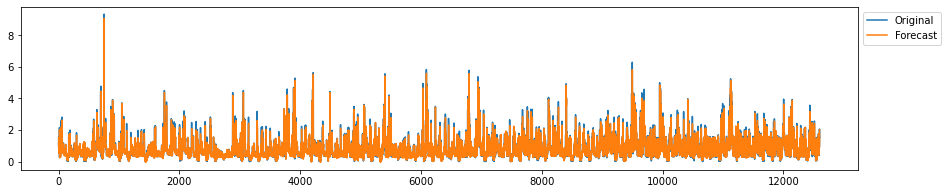

In [27]:
# fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[15, 3])
# ax.plot(inv_y, label='Original')
# ax.plot(inv_yhat, label='Forecast')
# handles, labels = ax.get_legend_handles_labels()
# lgd = ax.legend(handles, labels, loc=2, bbox_to_anchor=(1, 1))
# plt.show()

## Model: SARIMAX - Final model

In [ ]:
#ARIMA(0,0,1)(0,1,1)[7] ==> 1.298772	0.719836	284.08034	27.289521        
#ARIMA(0,0,1)(0,1,0)[7] ==> 1.385476	0.849953	338.81325	36.947232
#ARIMA(0,0,1)(1,1,0)[7] ==> 1.369081	0.826415	325.134299	34.910417
#ARIMA(0,0,1)(0,1,1)[7] ==> 1.315577	0.738525	287.562907	29.931525

In [47]:
def train_sarimax(endog, exog, order, seasonal_order):
    model=sm.tsa.SARIMAX(endog = endog, exog = exog, 
                          order=(0,0,1),
                          seasonal_order=(1,1,1,7), 
                         enforce_invertibility=False, 
                         enforce_stationarity=False)
    sarimax = model.fit()
    return sarimax


def test_sarimax(model,start,end,exog):
    forecasts = model.predict(start=start, end=end, exog=exog)
    return forecasts
    

In [48]:
def transform_original(test_X,test_y,yhat):
    test_X = test_X.reshape((test_X.shape[0], test_X.shape[1]))
    # invert scaling for forecast
    inv_yhat = np.concatenate((yhat.reshape(len(yhat),1), test_X[:, 1:]), axis=1)
    inv_yhat = scaler.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:,0]
    # invert scaling for actual - observed data
    test_y = test_y.reshape((len(test_y), 1))
    inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
    inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:,0]
    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[15, 3])
    ax.plot(inv_y, label='Original')
    ax.plot(inv_yhat, label='Forecast')
    handles, labels = ax.get_legend_handles_labels()
    lgd = ax.legend(handles, labels, loc=2, bbox_to_anchor=(1, 1))
    plt.show()
    
    return inv_y,inv_yhat

## Sliding Window PyFTS: SARIMAX

--------------------
training window 0


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


[ 22:51:31] getting statistics


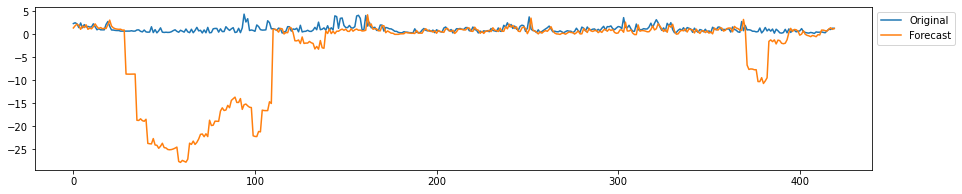

--------------------
training window 1679


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


[ 22:52:06] getting statistics


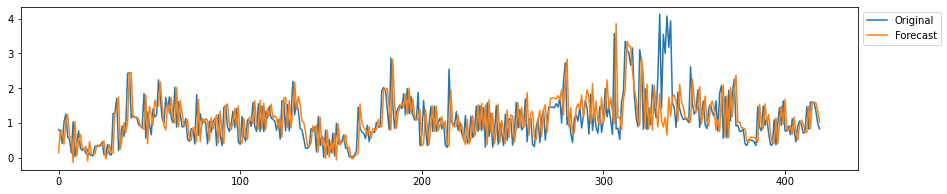

--------------------
training window 3358


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


[ 22:52:40] getting statistics


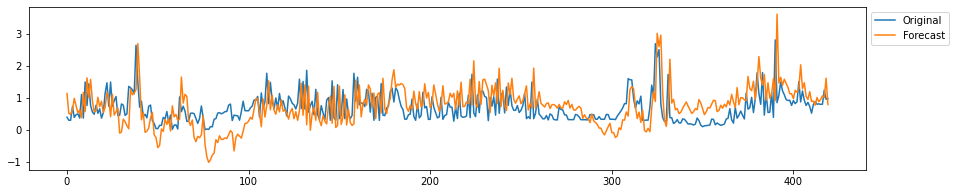

--------------------
training window 5037


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


[ 22:53:15] getting statistics


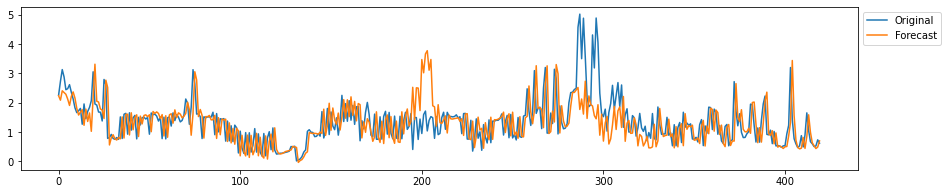

--------------------
training window 6716


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


[ 22:53:48] getting statistics


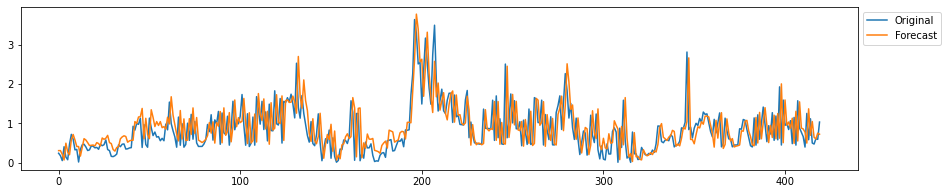

--------------------
training window 8395


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


[ 22:54:22] getting statistics


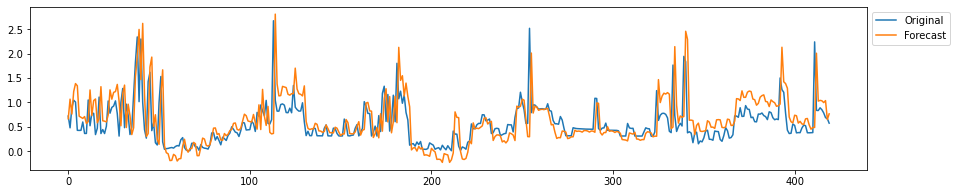

--------------------
training window 10074


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


[ 22:54:51] getting statistics


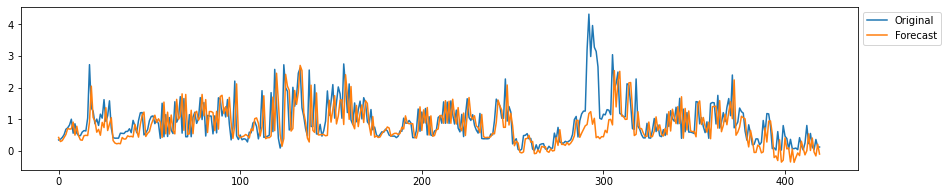

--------------------
training window 11753


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


[ 22:55:21] getting statistics


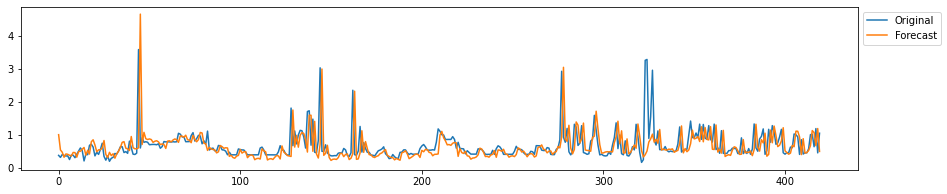

--------------------
training window 13432


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


[ 22:55:53] getting statistics


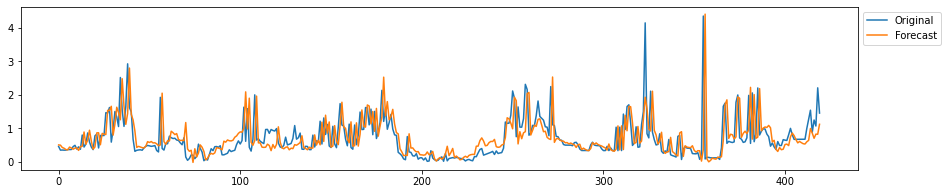

--------------------
training window 15111


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


[ 22:56:29] getting statistics


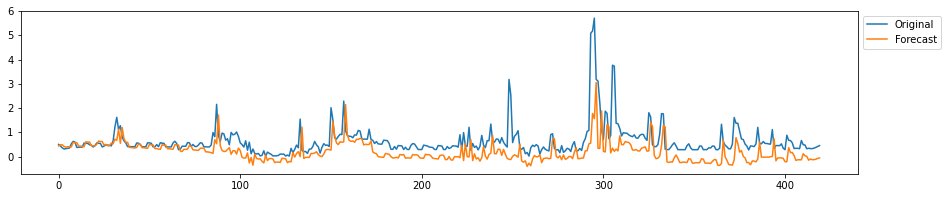

--------------------
training window 16790


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


[ 22:57:08] getting statistics


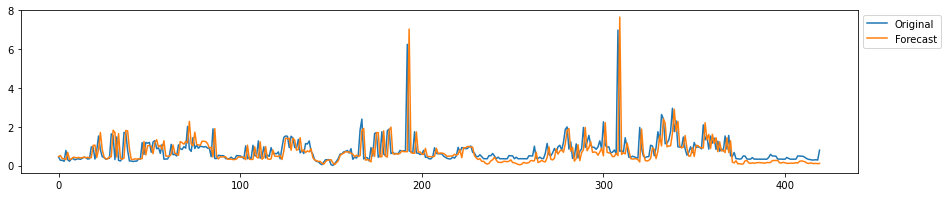

--------------------
training window 18469


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


[ 22:58:01] getting statistics


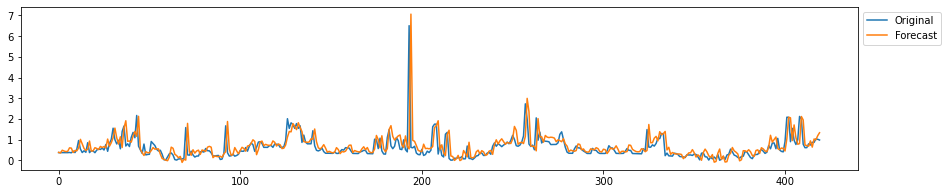

--------------------
training window 20148


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


[ 22:58:37] getting statistics


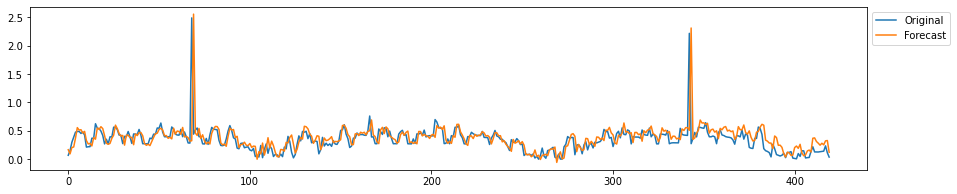

--------------------
training window 21827


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


[ 22:59:14] getting statistics


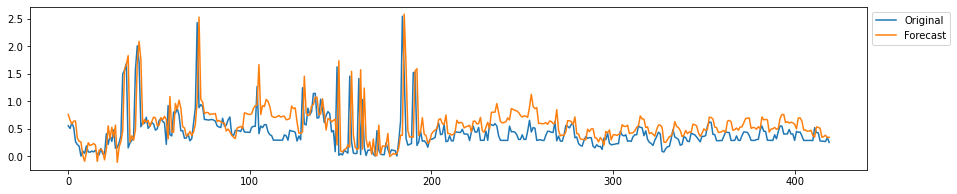

--------------------
training window 23506


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


[ 22:59:48] getting statistics


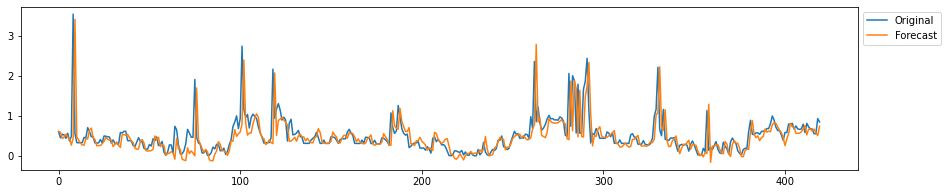

--------------------
training window 25185


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


[ 23:00:22] getting statistics


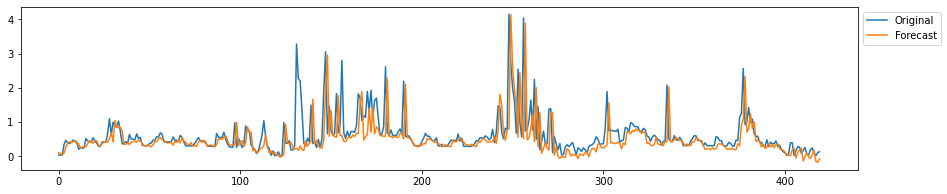

--------------------
training window 26864


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


[ 23:00:57] getting statistics


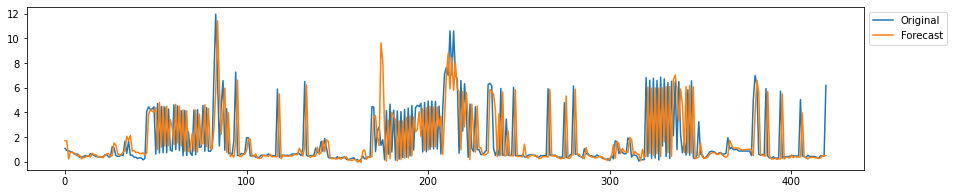

--------------------
training window 28543


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


[ 23:01:28] getting statistics


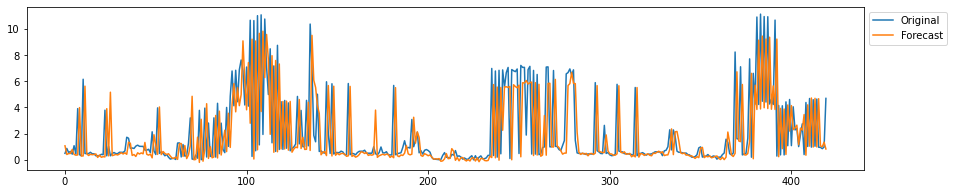

--------------------
training window 30222


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


[ 23:02:03] getting statistics


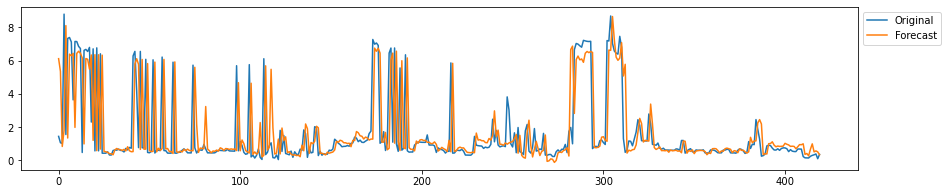

--------------------
training window 31901


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


[ 23:02:36] getting statistics


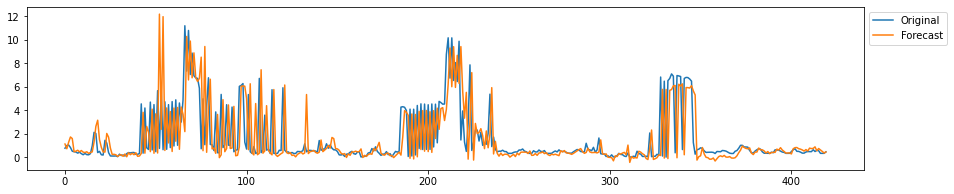

--------------------
training window 33580


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


[ 23:03:10] getting statistics


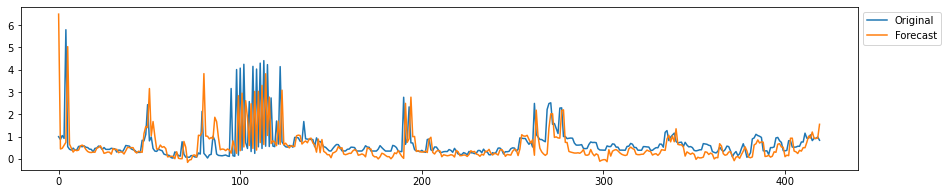

--------------------
training window 35259


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


[ 23:03:44] getting statistics


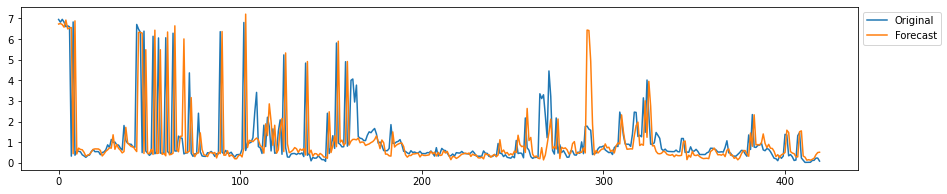

--------------------
training window 36938


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


[ 23:04:18] getting statistics


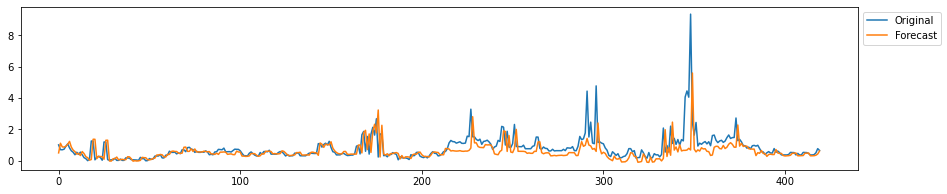

--------------------
training window 38617


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


[ 23:04:53] getting statistics


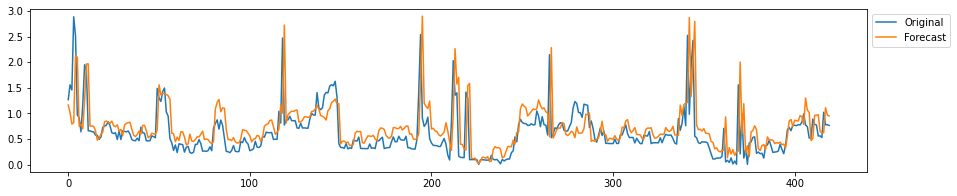

--------------------
training window 40296


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


[ 23:05:28] getting statistics


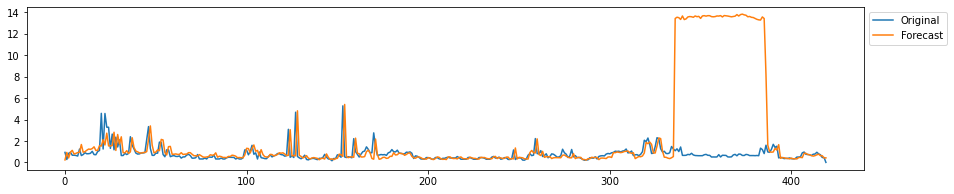

--------------------
training window 41975


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


[ 23:05:58] getting statistics


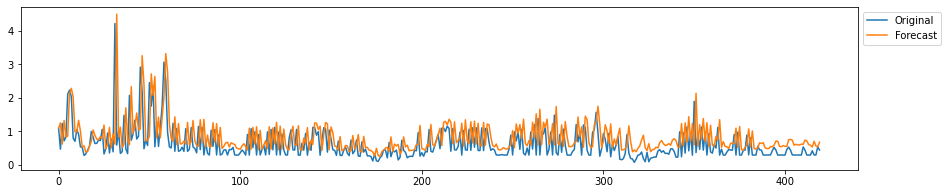

--------------------
training window 43654


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


[ 23:06:37] getting statistics


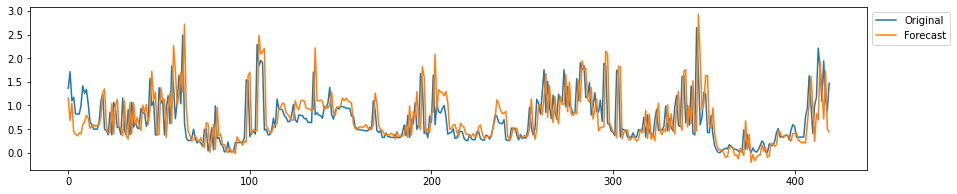

--------------------
training window 45333


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


[ 23:07:15] getting statistics


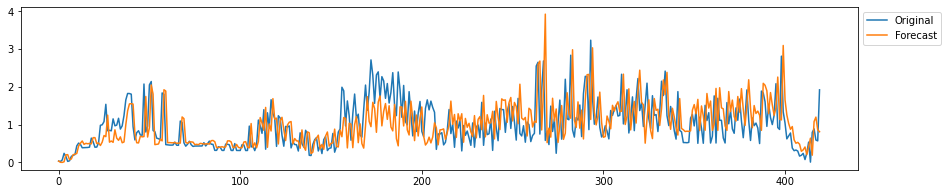

--------------------
training window 47012


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


[ 23:07:50] getting statistics


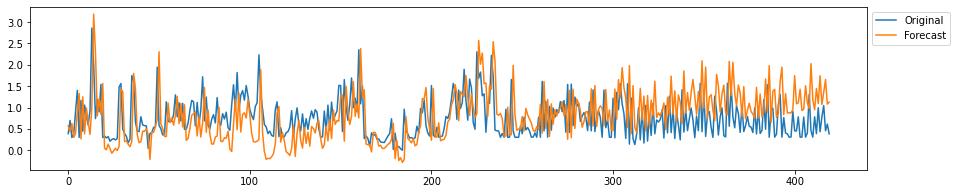

--------------------
training window 48691


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


[ 23:08:28] getting statistics


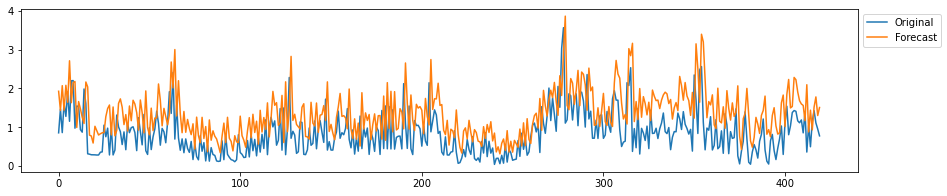

In [49]:
result = {
     "window": [],
     "rmse": [],
     "mae": [],
     "mape": [],
     "smape": []
}

tam = len(data)
n_windows = 30
windows_length = math.floor(tam / n_windows)
for ct, ttrain, ttest in Util.sliding_window(data_scaled, windows_length, 0.75, inc=1):
    if len(ttest) > 0:
        
        start = len(ttrain)
        end = len(ttrain)+ len(ttest) -1
        
        print('-' * 20)
        print(f'training window {(ct)}')
        model = train_sarimax(ttrain.loc[:,'use [kW](t-1)'], 
                              ttrain.loc[:,'gen [kW](t-1)':'precipProbability(t-1)'], 
                              [0,0,1], 
                              [1,1,1,7])
        yhat = test_sarimax(model, start, end, ttest.loc[:,'gen [kW](t-1)':'precipProbability(t-1)']) 
        
        print("[{0: %H:%M:%S}]".format(datetime.datetime.now()) + f" getting statistics")

        test_X = ttest.loc[:,'use [kW](t-1)':'precipProbability(t-1)'].values
        test_X = test_X.reshape((test_X.shape[0],test_X.shape[1]))
        test_y = ttest['use [kW](t)'].values 

        appliances,forecast = transform_original(test_X = test_X,test_y = test_y,yhat = yhat.values)
        
        rmse = Measures.rmse(appliances,forecast)
        mape = Measures.mape(appliances,forecast)
        smape = Measures.smape(appliances,forecast)
        
        forecast = pd.DataFrame(forecast)
        forecast.fillna(forecast.mean(),inplace=True)
        forecast = np.array(forecast).reshape(-1)
        mae = mean_absolute_error(appliances, forecast)
                
        result["rmse"].append(rmse)
        result["mae"].append(mae)
        result["mape"].append(mape)
        result["smape"].append(smape)
        result["window"].append(ct)

measures = pd.DataFrame(result)


In [50]:
measures

,window,rmse,mae,mape,smape
0,0,9.498533,4.872790,673.163942,52.313210
1,1679,0.725195,0.534635,90.678599,27.164152
2,3358,0.628647,0.504196,160.641568,40.356476
3,5037,0.757220,0.534817,54.631911,21.079534
4,6716,0.533608,0.404161,122.551561,25.625660
5,8395,0.431799,0.278783,80.431456,27.716746
6,10074,0.674828,0.462359,92.254014,30.029088
7,11753,0.507036,0.252891,36.318584,15.846045
8,13432,0.562865,0.333829,102.087689,23.958617
9,15111,0.714084,0.479149,98.487284,61.882819


### Mean Statistics SARIMAX

In [51]:
final_result = {
     "rmse": [],
     "mae": [],
     "mape": [],
     "smape": []
}

final_result["rmse"].append(statistics.mean(measures['rmse']))
final_result["mae"].append(statistics.mean(measures['mae']))
final_result["mape"].append(statistics.mean(measures['mape']))
final_result["smape"].append(statistics.mean(measures['smape']))
        
final_measures_pca = pd.DataFrame(final_result)

print("Mean Statistics SARIMAX (test): ")
final_measures_pca

Mean Statistics SARIMAX (test): 


,rmse,mae,mape,smape
0,1.315577,0.738525,287.562907,29.931525
